In [1]:
import re
import os

import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from PIL import Image

Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def list_dataset():
    for dirname, _, filenames in os.walk('D:/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))


In [4]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [5]:
def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]

In [6]:
IMAGES_DIR = 'D:/G Data/Garbage classification/Garbage classification'

In [7]:
train_file = 'D:/G Data/one-indexed-files-notrash_train.txt'
val_file   = 'D:/G Data/one-indexed-files-notrash_val.txt'
test_file  = 'D:/G Data/one-indexed-files-notrash_test.txt'

In [8]:
df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])

In [9]:
df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

In [10]:
df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

In [11]:
print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 328 samples.


In [12]:
df_train.head()

,rel_path,label
0,cardboard/cardboard202.jpg,cardboard
1,paper/paper472.jpg,paper
2,paper/paper522.jpg,paper
3,glass/glass189.jpg,glass
4,glass/glass325.jpg,glass


In [13]:
df_test.head()

,rel_path,label
0,cardboard/cardboard114.jpg,cardboard
1,plastic/plastic204.jpg,plastic
2,glass/glass123.jpg,glass
3,glass/glass152.jpg,glass
4,glass/glass398.jpg,glass


In [14]:
df_valid.head()

,rel_path,label
0,cardboard/cardboard114.jpg,cardboard
1,plastic/plastic204.jpg,plastic
2,glass/glass123.jpg,glass
3,glass/glass152.jpg,glass
4,glass/glass398.jpg,glass


In [15]:
datagen = ImageDataGenerator()

datagen_train = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_valid = datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


In [16]:
def build_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    return model

In [17]:
net = build_model(num_classes=6)

In [18]:
net.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.categorical_accuracy])

In [19]:
net

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = net.fit_generator(
    generator=datagen_train,
    validation_data=datagen_valid,
    epochs=30,
    validation_freq=1,
    callbacks=[early_stop]
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 56 steps, validate for 11 steps
Epoch 1/30
56/56 [==============================] - 28s 496ms/step - loss: 1.1193 - categorical_accuracy: 0.6686 - val_loss: 0.9543 - val_categorical_accuracy: 0.6524
Epoch 2/30
56/56 [==============================] - 13s 234ms/step - loss: 0.4033 - categorical_accuracy: 0.8654 - val_loss: 1.0274 - val_categorical_accuracy: 0.6524
Epoch 3/30
56/56 [==============================] - 13s 238ms/step - loss: 0.2021 - categorical_accuracy: 0.9333 - val_loss: 1.0296 - val_categorical_accuracy: 0.6951
Epoch 4/30
56/56 [==============================] - 13s 233ms/step - loss: 0.1320 - categorical_accuracy: 0.9615 - val_loss: 1.4781 - val_categorical_accuracy: 0.6311
Epoch 5/30
56/56 [==============================] - 13s 234ms/step - loss: 0.0747 - categorical_accuracy: 0.9825 - val_loss: 1.0389 - val_categorical_accuracy: 0.70

In [21]:
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=7
)

# y_pred = net.predict(test_generator, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

filenames = test_generator.filenames
nb_samples = len(filenames)

net.evaluate_generator(test_generator, nb_samples)

Found 328 validated image filenames belonging to 6 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


[0.9276240682792399, 0.652439]

In [ ]:
net.save('resnet50_gar.h5')

In [22]:
labels = (datagen_train.class_indices)
labels = dict((v,k) for k,v in labels.items())

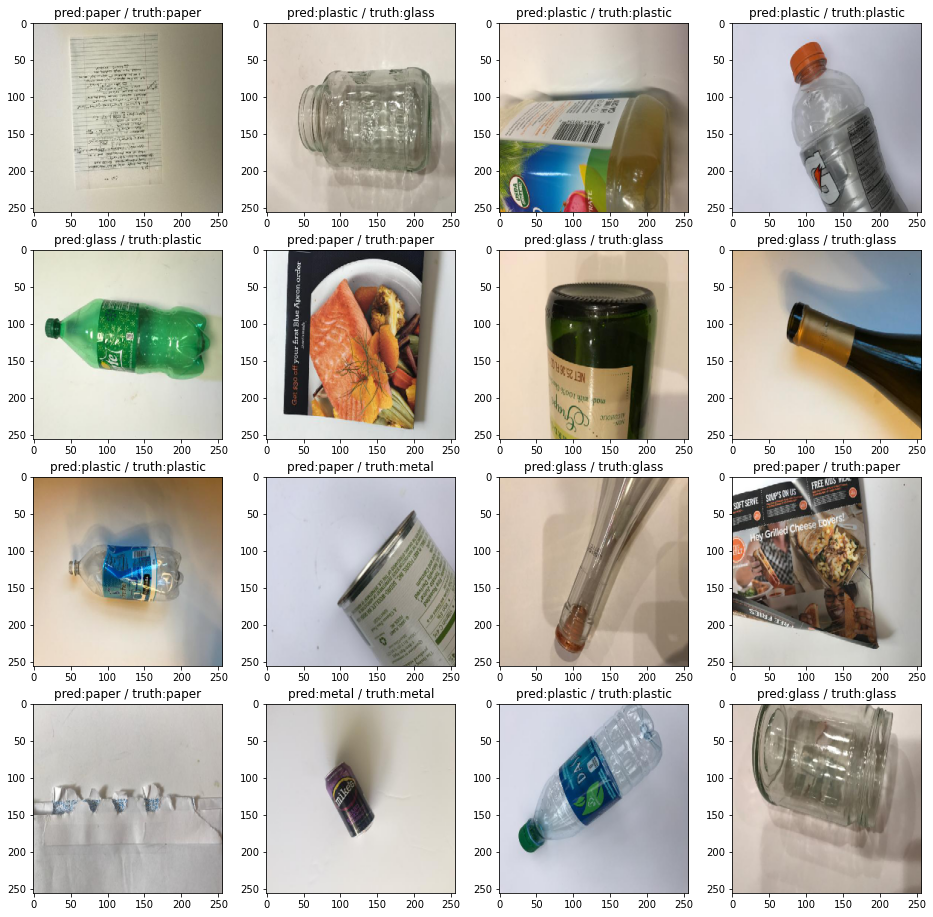

In [23]:
test_x, test_y = datagen_valid.__getitem__(1)

preds = net.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x.astype(int)[i])

In [24]:
loaded_model = tf.keras.models.load_model('models/resnet50_gar.h5')

In [26]:
def pred_img(x):
    img1 = Image.open(x).convert(mode="RGB")
    array1 = np.array(img1.getdata())
    img_np_array = np.reshape(array1, (256,256,3))

    plt.imshow(img_np_array.astype(int))
    a = np.expand_dims(img_np_array, axis=0)
    print(net.predict(a), labels)
    return labels[np.argmax(loaded_model.predict(a))]

[[2.2587717e-06 1.0502458e-02 6.9256820e-04 7.8984616e-05 9.8853928e-01
  1.8440746e-04]] {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


'plastic'

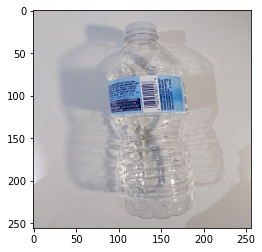

In [27]:
pred_img('test_images/bottle.jpg')

[[0.05721673 0.05004987 0.00542805 0.80784583 0.03942833 0.04003127]] {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


'paper'

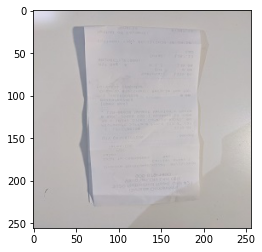

In [28]:
pred_img('test_images/paper_receipt.jpg')

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
# tflite_model = converter.convert()